# Implementez un modèle de scoring

## Import des libraries

## Rapple de la mission
Construire un modèle de scoring qui donnera une prédiction sur la probabilité de faillite d'un client de façon automatique.

In [529]:
import time
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib. pyplot as plt
import lightgbm as lgb
from xgboost import XGBClassifier
from sklearn.preprocessing import PolynomialFeatures
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.model_selection import cross_val_score, StratifiedKFold, learning_curve
from sklearn.metrics import make_scorer, confusion_matrix
from sklearn.linear_model import LogisticRegression  
from sklearn.impute import SimpleImputer
from sklearn.ensemble import RandomForestClassifier
from sklearn.compose import make_column_selector, make_column_transformer
from lightgbm import LGBMClassifier
from IPython.display import display, HTML
from imblearn.pipeline import Pipeline
from imblearn.over_sampling import SMOTE
from contextlib import contextmanager

In [530]:
def display_info(title = "",titleTag="h2",tag="div",pTag="p",message="Params allowed: title,tag,message,color",bgd="#96d6ee", styleClass="alert alert-block alert-info", fontsize="" , color="black"):
    if (title!=""):
        display(HTML(f"""<{titleTag} style='color:{color};font-size:{fontsize}'>{title}</{titleTag}>"""))
    else:
        display(HTML(f"""
                     <{tag} style='background:{bgd}; padding-top:5px; padding-bottom:5px; padding-left:10px;' class='{styleClass}'><{pTag} style='color:{color}; font-size:{fontsize}'>{message}</{pTag}></{tag}>
"""))

In [531]:
app_train = pd.read_csv('../datas/application_train.csv')

In [532]:
@contextmanager
def timer(title):
    t0=time.time()
    yield
    print("{} - terminé en {:.000f}s".format(title, time.time()-t0))

In [533]:
display_info(message="On traite les valeurs impossible ici")
def manage_imp_value(df):
    df.loc[df['CNT_CHILDREN'] > 7 , 'CNT_CHILDREN'] = np.nan
    df['DAYS_EMPLOYED'].replace({365243:np.nan}, inplace=True)
    return df

In [534]:
def featureImportCalc(X,y, preprocessor):
    model=lgb.LGBMClassifier()
    model.fit(X,y)

    importances = model.feature_importances_
    indices = importances.argsort()
    feature_names = preprocessor.get_feature_names_out()
    feature_names_clean = [name.split('__')[-1] for name in feature_names]  # Supprimer les préfixes


    feature_importances = pd.DataFrame({
        "feature": feature_names_clean,
        "Importance" : importances,
    })
    return importances, indices, feature_names_clean, feature_importances 

In [535]:

def preprocessing():
    # display_info(message="On sépare nos variable numérique de nos variable qualitative")
    numerical_features = make_column_selector(dtype_include=np.number)
    categorical_features = make_column_selector(dtype_exclude=np.number)
    # display_info(message=f"""On obtient donc {numerical_features.shape[0]} numerical_features \n
    #               et {categorical_features.shape[1]} categorical_features""")

    # display_info(message="On creer un pipeline pour chaque type de variables")
    numerical_pipeline = Pipeline([
        ("imputer",SimpleImputer(strategy="mean")),
        ("scaler",StandardScaler())
        ])
    # display_info(message=f"""Pour les feature numerique numerical_pipeline =  {numerical_pipeline}""")


    categorical_pipeline = Pipeline([
        ("imputer",SimpleImputer(strategy='most_frequent')),
        ("encoder",OneHotEncoder(handle_unknown="ignore"))
        ])
    # display_info(message=f"""Pour les feature categoriels categorical_pipeline =  {categorical_pipeline}""")

    # categorical_pipeline = Pipeline(SimpleImputer(strategy='most_frequent'), OneHotEncoder())


    preprocessor =make_column_transformer(
        (numerical_pipeline,numerical_features),
        (categorical_pipeline, categorical_features)
        )
    return preprocessor

In [552]:
def split_df(df):
    X_train,X_val= train_test_split(df,test_size=0.2, stratify=df['TARGET'], random_state=42)
    
    X=X_train.drop('TARGET', axis=1)
    y=X_train['TARGET']
    X_train, X_test, y_train, y_test=train_test_split(X,y, test_size=0.2, stratify=y, random_state=42)
    return X_train, X_test, y_train, y_test


In [537]:
def getfeatureImportances(X_train, X_test, y_train, y_test):
    preprocessor = preprocessing()

    X_train = preprocessor.fit_transform(X_train)
    importances, indices, feature_names, feature_importances = featureImportCalc(X_train, y_train, preprocessor)
    
    X_transformed = pd.DataFrame(X_train, columns=feature_names)
    variances = X_transformed.var()

    name = 'LightGBM'
    importances_df = pd.DataFrame({
        'Features': feature_names,
        f'{name} Importances':importances,
        f'Variance':variances.values
    })

    # Fonction pour réorganiser l'ordre des colonnes en fonction du tri
    def reorder_columns(df, primary_model):
        cols = ['Features', primary_model] + [col for col in df.columns if col != 'Features' and col != primary_model]
        return df[cols]

    display_info(message=f"=== Feature importance classé par ordre décroissant sur {name} ===")
    importances_dfLGBM = importances_df.sort_values(by=f'{name} Importances', ascending=False)
    importances_lgbm_reordered = reorder_columns(importances_dfLGBM, f'{name} Importances')
    display(importances_lgbm_reordered)

    return importances_lgbm_reordered


In [538]:
def feature_selection(df):
    treshold = 50 # cumulative importance max
    varianceTreshold = 1 # cumulative importance max
    df = df.sort_values(by='LightGBM Importances',ascending=False)
    df['Cumulative Importance %'] = ((df['LightGBM Importances']*100)/ df['LightGBM Importances'].sum()).cumsum()

    df = df[(df['Cumulative Importance %']<treshold) & (df['Variance']>int(varianceTreshold))]
    return df

In [ ]:
def feature_importance_Choice(X_train,feature_selected):

    # importances_lgbm_reordered= getfeatureImportances(X_train, X_test, y_train, y_test)
    display_info(message="On selectionne les feature qui font partie des 50% les plus représentées de notre dataset et une variance  > 1")
    # feature_selected =feature_selection(importances_lgbm_reordered)
    display(feature_selected['Features'].count())
    display(feature_selected)
    preprocessor= preprocessing() ## Recuperation du pipeline de preprocessing

    df_with_feature_selected = X_train[feature_selected['Features']] ## selection dans Xtrain des feature retenu 
    df_with_feature_selected = preprocessor.fit_transform(df_with_feature_selected) ## traitement des données avec les preprocessing
    feature_names = preprocessor.get_feature_names_out() ## on recupère le nom des features 
    feature_names = [name.split('__')[-1] for name in feature_names]
    df_with_feature_selected = pd.DataFrame(df_with_feature_selected,columns=feature_names) ## on reafecte le nom à chaque feature
    display_info(message="DataFrame avec les feature selectionnées en fonction de leurs importances")
    display(df_with_feature_selected)
    display_info(message="Regardons la correlation de pearson pour les features selectionnées avant de créer nos polynomiales feature")

    correlation_matrix = df_with_feature_selected.corr(method='pearson')
    matrix = np.triu(correlation_matrix)

    sns.heatmap(correlation_matrix, annot=True, mask=matrix)

    return df_with_feature_selected

/var/folders/gk/r5q0c38n70s02t1z45pl1x400000gp/T/ipykernel_16963/1567189995.py:4: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df['DAYS_EMPLOYED'].replace({365243:np.nan}, inplace=True)


(196806, 121)
[LightGBM] [Info] Number of positive: 15888, number of negative: 180918
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.023546 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 11845
[LightGBM] [Info] Number of data points in the train set: 196806, number of used features: 233
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.080729 -> initscore=-2.432480
[LightGBM] [Info] Start training from score -2.432480


,Features,LightGBM Importances,Variance
28,EXT_SOURCE_1,217,1.000005
30,EXT_SOURCE_3,215,1.000005
29,EXT_SOURCE_2,198,1.000005
7,DAYS_BIRTH,165,1.000005
3,AMT_CREDIT,140,1.000005
...,...,...,...
81,FLAG_DOCUMENT_4,0,1.000005
171,ORGANIZATION_TYPE_Advertising,0,0.001319
83,FLAG_DOCUMENT_6,0,1.000005
84,FLAG_DOCUMENT_7,0,1.000005


np.int64(9)

,Features,LightGBM Importances,Variance,Cumulative Importance %
28,EXT_SOURCE_1,217,1.000005,7.233333
30,EXT_SOURCE_3,215,1.000005,14.400000
29,EXT_SOURCE_2,198,1.000005,21.000000
7,DAYS_BIRTH,165,1.000005,26.500000
3,AMT_CREDIT,140,1.000005,31.166667
8,DAYS_EMPLOYED,128,1.000005,35.433333
10,DAYS_ID_PUBLISH,119,1.000005,39.400000
5,AMT_GOODS_PRICE,116,1.000005,43.266667
4,AMT_ANNUITY,106,1.000005,46.800000


,EXT_SOURCE_1,EXT_SOURCE_3,EXT_SOURCE_2,DAYS_BIRTH,AMT_CREDIT,DAYS_EMPLOYED,DAYS_ID_PUBLISH,AMT_GOODS_PRICE,AMT_ANNUITY
0,1.589111e-15,-6.372508e-16,-0.646817,-0.841308,0.519417,0.263304,-0.157544,0.368835,-0.230262
1,-2.934472e-01,-1.647862e+00,0.639618,0.463433,0.332453,-0.309296,-0.789022,0.381012,0.831998
2,-1.677312e-01,5.560069e-03,0.667931,-0.461456,-0.109410,-1.270212,0.938921,-0.203478,-0.625046
3,-3.263536e+00,-1.559498e+00,-0.218215,-0.000959,0.585756,0.974589,0.477915,0.368835,0.909157
4,1.589111e-15,5.249847e-01,-0.081859,-0.458935,2.791667,0.545373,0.950197,2.195365,1.613199
...,...,...,...,...,...,...,...,...,...
196801,-6.184661e-01,-6.978752e-01,0.001869,1.752594,-0.817397,0.828853,1.295786,-0.727083,-0.937712
196802,1.589111e-15,-7.273320e-01,0.423767,-0.308415,-0.929077,-1.600233,1.368088,-0.848851,-1.076228
196803,1.589111e-15,-6.372508e-16,-1.304998,0.948214,-0.193774,-0.652481,-0.408941,-0.240008,-0.277363
196804,1.589111e-15,2.833257e-01,1.348495,-0.514607,-0.873237,-3.540400,0.783041,-0.787967,-1.015182


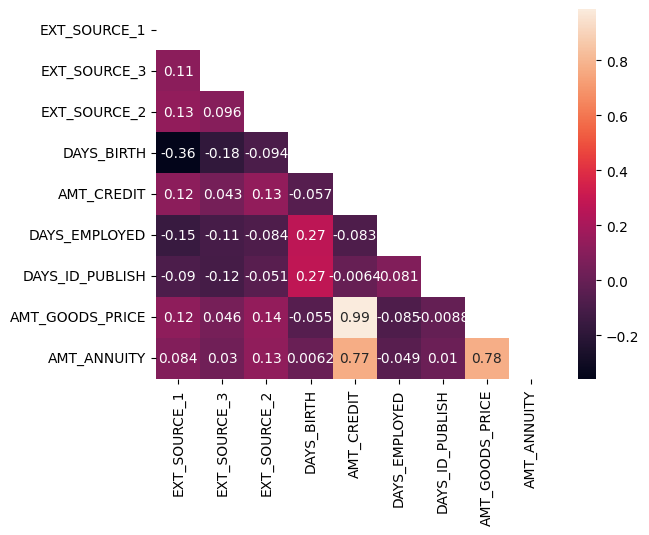

In [553]:
df = app_train.copy()
X_train, X_test, y_train, y_test = split_df(manage_imp_value(df))
print(X_train.shape)

# importances_lgbm_reordered= getfeatureImportances(X_train, X_test, y_train, y_test)

df_with_feature_selected= feature_importance_Choice(X_train,feature_selection(getfeatureImportances(X_train, X_test, y_train, y_test)))

In [554]:
def poly_feature_creation(df):
    poly_transformer = PolynomialFeatures(degree=2, include_bias=False)
    X_poly = poly_transformer.fit_transform(df)
    df.columns = df.columns.astype(str)
    poly_feature_names = poly_transformer.get_feature_names_out(input_features=df.columns)
    df_poly = pd.DataFrame(X_poly, columns=poly_feature_names)
    display_info(message="df_poly de polyfeature_creation")
    display(df_poly)
    df_poly['TARGET'] = app_train['TARGET']

    return df_poly

In [555]:
def get_feat_importanceOnPoly(df_poly):
    X_train, X_test, y_train, y_test = split_df(df_poly)
    importances_lgbm_reordered =getfeatureImportances(X_train, X_test, y_train, y_test)
    df=feature_selection(importances_lgbm_reordered)
    return df

,EXT_SOURCE_1,EXT_SOURCE_3,EXT_SOURCE_2,DAYS_BIRTH,AMT_CREDIT,DAYS_EMPLOYED,DAYS_ID_PUBLISH,AMT_GOODS_PRICE,AMT_ANNUITY,EXT_SOURCE_1^2,...,DAYS_EMPLOYED^2,DAYS_EMPLOYED DAYS_ID_PUBLISH,DAYS_EMPLOYED AMT_GOODS_PRICE,DAYS_EMPLOYED AMT_ANNUITY,DAYS_ID_PUBLISH^2,DAYS_ID_PUBLISH AMT_GOODS_PRICE,DAYS_ID_PUBLISH AMT_ANNUITY,AMT_GOODS_PRICE^2,AMT_GOODS_PRICE AMT_ANNUITY,AMT_ANNUITY^2
0,1.589111e-15,-6.372508e-16,-0.646817,-0.841308,0.519417,0.263304,-0.157544,0.368835,-0.230262,2.525275e-30,...,0.069329,-0.041482,0.097116,-0.060629,0.024820,-0.058108,0.036276,0.136039,-0.084929,0.053021
1,-2.934472e-01,-1.647862e+00,0.639618,0.463433,0.332453,-0.309296,-0.789022,0.381012,0.831998,8.611127e-02,...,0.095664,0.244042,-0.117846,-0.257334,0.622556,-0.300627,-0.656465,0.145170,0.317001,0.692220
2,-1.677312e-01,5.560069e-03,0.667931,-0.461456,-0.109410,-1.270212,0.938921,-0.203478,-0.625046,2.813377e-02,...,1.613439,-1.192629,0.258460,0.793941,0.881572,-0.191049,-0.586869,0.041403,0.127183,0.390683
3,-3.263536e+00,-1.559498e+00,-0.218215,-0.000959,0.585756,0.974589,0.477915,0.368835,0.909157,1.065066e+01,...,0.949823,0.465771,0.359462,0.886055,0.228403,0.176272,0.434500,0.136039,0.335329,0.826567
4,1.589111e-15,5.249847e-01,-0.081859,-0.458935,2.791667,0.545373,0.950197,2.195365,1.613199,2.525275e-30,...,0.297432,0.518212,1.197294,0.879796,0.902875,2.086030,1.532857,4.819626,3.541560,2.602411
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
196801,-6.184661e-01,-6.978752e-01,0.001869,1.752594,-0.817397,0.828853,1.295786,-0.727083,-0.937712,3.825003e-01,...,0.686997,1.074016,-0.602645,-0.777226,1.679061,-0.942144,-1.215074,0.528649,0.681795,0.879304
196802,1.589111e-15,-7.273320e-01,0.423767,-0.308415,-0.929077,-1.600233,1.368088,-0.848851,-1.076228,2.525275e-30,...,2.560747,-2.189259,1.358360,1.722215,1.871664,-1.161303,-1.472374,0.720549,0.913557,1.158266
196803,1.589111e-15,-6.372508e-16,-1.304998,0.948214,-0.193774,-0.652481,-0.408941,-0.240008,-0.277363,2.525275e-30,...,0.425731,0.266826,0.156601,0.180974,0.167233,0.098149,0.113425,0.057604,0.066570,0.076931
196804,1.589111e-15,2.833257e-01,1.348495,-0.514607,-0.873237,-3.540400,0.783041,-0.787967,-1.015182,2.525275e-30,...,12.534430,-2.772279,2.789718,3.594149,0.613153,-0.617011,-0.794929,0.620892,0.799930,1.030594


[LightGBM] [Info] Number of positive: 10239, number of negative: 115716
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002642 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 13767
[LightGBM] [Info] Number of data points in the train set: 125955, number of used features: 54
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.081291 -> initscore=-2.424935
[LightGBM] [Info] Start training from score -2.424935


,Features,LightGBM Importances,Variance
48,DAYS_ID_PUBLISH^2,105,1.000008
26,EXT_SOURCE_2^2,104,1.000008
33,DAYS_BIRTH^2,92,1.000008
53,AMT_ANNUITY^2,86,1.000008
30,EXT_SOURCE_2 DAYS_ID_PUBLISH,78,1.000008
45,DAYS_EMPLOYED DAYS_ID_PUBLISH,71,1.000008
23,EXT_SOURCE_3 DAYS_ID_PUBLISH,71,1.000008
47,DAYS_EMPLOYED AMT_ANNUITY,70,1.000008
24,EXT_SOURCE_3 AMT_GOODS_PRICE,69,1.000008
6,DAYS_ID_PUBLISH,68,1.000008


np.int64(8)

,Features,LightGBM Importances,Variance,Cumulative Importance %
48,DAYS_ID_PUBLISH^2,105,1.000008,7.196710
26,EXT_SOURCE_2^2,104,1.000008,14.324880
33,DAYS_BIRTH^2,92,1.000008,20.630569
53,AMT_ANNUITY^2,86,1.000008,26.525017
30,EXT_SOURCE_2 DAYS_ID_PUBLISH,78,1.000008,31.871145
45,DAYS_EMPLOYED DAYS_ID_PUBLISH,71,1.000008,36.737491
23,EXT_SOURCE_3 DAYS_ID_PUBLISH,71,1.000008,41.603838
47,DAYS_EMPLOYED AMT_ANNUITY,70,1.000008,46.401645


,DAYS_ID_PUBLISH^2,EXT_SOURCE_2^2,DAYS_BIRTH^2,AMT_ANNUITY^2,EXT_SOURCE_2 DAYS_ID_PUBLISH,DAYS_EMPLOYED DAYS_ID_PUBLISH,EXT_SOURCE_3 DAYS_ID_PUBLISH,DAYS_EMPLOYED AMT_ANNUITY
0,-1.029628,-0.440985,-0.299869,-0.310081,0.152283,-0.124702,0.116791,-0.011218
1,-0.398518,-0.448007,-0.805838,-0.100780,-0.452175,0.164885,1.433971,-0.202298
2,-0.125040,-0.419939,-0.807715,-0.199516,0.675682,-1.292230,0.122080,0.818912
3,-0.814678,-0.722089,-1.026244,-0.056789,-0.053188,0.389769,-0.638249,0.908391
4,-0.102548,-0.753112,-0.810095,0.524697,-0.026775,0.442958,0.622145,0.902312
...,...,...,...,...,...,...,...,...
196801,0.716976,-0.758190,2.125954,-0.039521,0.053149,1.006671,-0.799315,-0.707321
196802,0.920332,-0.622037,-0.928628,0.051823,0.628464,-2.303043,-0.891257,1.720639
196803,-0.879264,0.533023,-0.103538,-0.302252,0.582541,0.187994,0.116791,0.223475
196804,-0.408446,0.620534,-0.754474,0.010018,1.102978,-2.894359,0.341544,3.539038


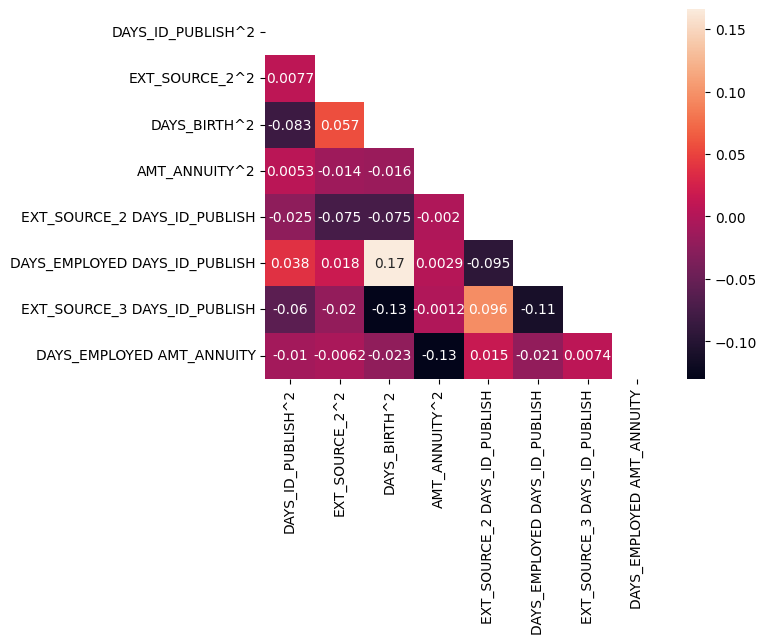

In [558]:
display_info(title="Polynomial feature", color='red', fontsize='30px')
df_poly= poly_feature_creation(df_with_feature_selected)
# df = feature_selection(get_feat_importanceOnPoly(df_poly))
# display(df)
df = feature_importance_Choice(df_poly,feature_selection(get_feat_importanceOnPoly(df_poly)))


In [20]:
display_info(message="""En lisant la documentations sklearn, on comprend que le SMOTE est en version expérimental. On utilisera donc imblearn qui en plus est facilement intégrable dans un pipeline""")

In [559]:
display_info(title="PIPELINE", color="red",fontsize="30px")
display_info(message="""La correlation des feature polynomial est moins évidente qu'avec les features original. De plus on conserve avec la selection orginal les features EXT_SOURCE_1, EXT_SOURCE_2 et EXT_SOURCE_3 qui sont considérées comme importantes. </br>
             On garde donc nos features de base sans création de polynomiales""")
display_info(message="""On va realiser notre modelisation en automatisant toute notre logique.</br>
             On va donc utiliser le plus possible les pipeline mis à disposition dans sklearn""")
display_info(message="On commence par séparer nos variable en utilisant make_column_selector")

In [73]:
display_info(message="On sépare nos variable numérique de nos variable qualitative")
numerical_features = make_column_selector(dtype_include=np.number)
categorical_features = make_column_selector(dtype_exclude=np.number)
# display_info(message=f"""On obtient donc {numerical_features.shape[0]} numerical_features \n
#               et {categorical_features.shape[1]} categorical_features""")

display_info(message="On creer un pipeline pour chaque type de variables")
numerical_pipeline = Pipeline([
    ("imputer",SimpleImputer(strategy="mean")),
    ("scaler",StandardScaler())
    ])
display_info(message=f"""Pour les feature numerique numerical_pipeline =  {numerical_pipeline}""")


categorical_pipeline = Pipeline([
    ("imputer",SimpleImputer(strategy='most_frequent')),
    ("encoder",OneHotEncoder(handle_unknown="ignore"))
    ])
display_info(message=f"""Pour les feature categoriels categorical_pipeline =  {categorical_pipeline}""")

# categorical_pipeline = Pipeline(SimpleImputer(strategy='most_frequent'), OneHotEncoder())


preprocessor =make_column_transformer(
    (numerical_pipeline,numerical_features),
    (categorical_pipeline, categorical_features)
    )
display_info(message=f"On creer un pipeline générale qui va appliquer la modifcation souhaité sur nos differents type de variables {categorical_pipeline}")

models = {
    'RandomForest': RandomForestClassifier(random_state=42),
    'LogisticRegression': LogisticRegression( random_state=42),
    'LGBM': LGBMClassifier(random_state=42),
    'XGBOOST': XGBClassifier(random_state=42)
    # dummyregressor
}

X_train, X_val= train_test_split(app_train,test_size=0.2, stratify=app_train['TARGET'], random_state=42)

display_info(message=f"""On split notre jeu de données une première fois on va entrainer et choisir nos modèle avec le jeu de donnée {X_train.shape}\n
On garde donc pour valider notre modèle X_val: {X_val.shape}""")

X=X_train.drop('TARGET', axis=1)
y=X_train['TARGET']

X_train,X_test,y_train,y_test=train_test_split(X,y, test_size=0.2, stratify=y, random_state=42)
display_info(message=f"""Puis on divise cette fois ci X_train pour l'entrainement et le test de notre modèle final on a donc pour l'entrainement X_train: {X_train.shape}\n
et pour le test du modèle X_text{X_test.shape}""")

def applyPipeline(model):
    model_pipeline = Pipeline([
            ("preprocessor",preprocessor),
            ("smote",SMOTE(random_state=42)),
            ("classifier",model)
        ])
    return model_pipeline

display_info(message="On doit s'occuper de notre score métier. Pour cela on utilise une fonction metier à l'aide de make_scorer")

def business_cost(y_true,y_pred, cost_FN=10, cost_FP=1):
    
    tn,fp,fn,tp = confusion_matrix(y_true, y_pred).ravel()

    total_cost = (cost_FN*fn) + (cost_FP *fp)

    return -total_cost

business_scorer = make_scorer(business_cost, greater_is_better=False)


# custom_score = make_scorer(custom_metric)
best_model_name = None
best_score = -float('inf')

for name, model in models.items():
    print(f"Démarrage du test du modèle {name}")
    with timer(f'Calcul du score pour le model {name}'):
        model_pipeline = applyPipeline(model)
        kf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
        scores = cross_val_score(model_pipeline, X_train, y_train, cv=kf, scoring=business_scorer)
        mean_score=scores.mean()
        print(f"Scores de validation croisée pour {name}:", scores)
        print(f"Scores moyen {name}:", mean_score)

        if mean_score > best_score:
            best_score=mean_score
            best_model_name=name
print("\nMeilleur modèle :", best_model_name)
print("\nScore moyen du meilleur modèle :", best_score)

Démarrage du test du modèle RandomForest
Scores de validation croisée pour RandomForest: [31746 31743 31726 31751 31757]
Scores moyen RandomForest: 31744.6
Calcul du score pour le model RandomForest - terminé en 547s
Démarrage du test du modèle LogisticRegression


/Users/yann/FromNas/Training/IA Engineer/P4/P4_scoringModel/P4_env/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/Users/yann/FromNas/Training/IA Engineer/P4/P4_scoringModel/P4_env/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative s

Scores de validation croisée pour LogisticRegression: [22134 21904 21910 21747 21917]
Scores moyen LogisticRegression: 21922.4
Calcul du score pour le model LogisticRegression - terminé en 38s
Démarrage du test du modèle LGBM
[LightGBM] [Info] Number of positive: 144734, number of negative: 144734
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.044779 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 50954
[LightGBM] [Info] Number of data points in the train set: 289468, number of used features: 236
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Info] Number of positive: 144734, number of negative: 144734
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.048337 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, yo

In [74]:
display_info(message=f" On va chercher les meilleurs hyper parametre afin d'améliorer le score de notre modèle {best_model_name}")

param_grid = {
    'LGBM': {
        'classifier__num_leaves': [31, 50, 70],
        'classifier__learning_rate': [0.1, 0.05, 0.01],
        'classifier__n_estimators': [100, 200, 500],
        'classifier__max_depth': [-1, 10, 20]
    },
    'RandomForest': {
        'classifier__n_estimators': [100, 200, 500],
        'classifier__max_depth': [None, 10, 20],
        'classifier__min_samples_split': [2, 5, 10],
        'classifier__min_samples_leaf': [1, 2, 4]
    },
    'LogisticRegression': {
        'classifier__C': [0.1, 1, 10],
        'classifier__solver': ['liblinear', 'lbfgs']
    },
    'XGBOOST': {
        'classifier__learning_rate': [0.1, 0.05, 0.01],
        'classifier__n_estimators': [100, 200, 500],
        'classifier__max_depth': [3, 5, 10],
        'classifier__subsample': [0.6, 0.8, 1.0]
    }
}

# model = LGBMClassifier(random_state=42)
model_pipeline = applyPipeline(models[best_model_name])
kf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

if name in param_grid:
    grid_search = GridSearchCV(model_pipeline,param_grid[best_model_name], cv=kf, scoring=business_scorer)
    # grid_search = GridSearchCV(model, param_grid, cv=5, scoring='roc_auc')
    grid_search.fit(X_test, y_test)    
    print(f"Meilleurs paramètres pour {name} :", grid_search.best_params_)
    print(f"Score moyen pour {name} :", grid_search.best_score_)
    
# print("Meilleur score :", grid_search.)

KeyboardInterrupt: 

In [ ]:
param_grid[best_model_name]

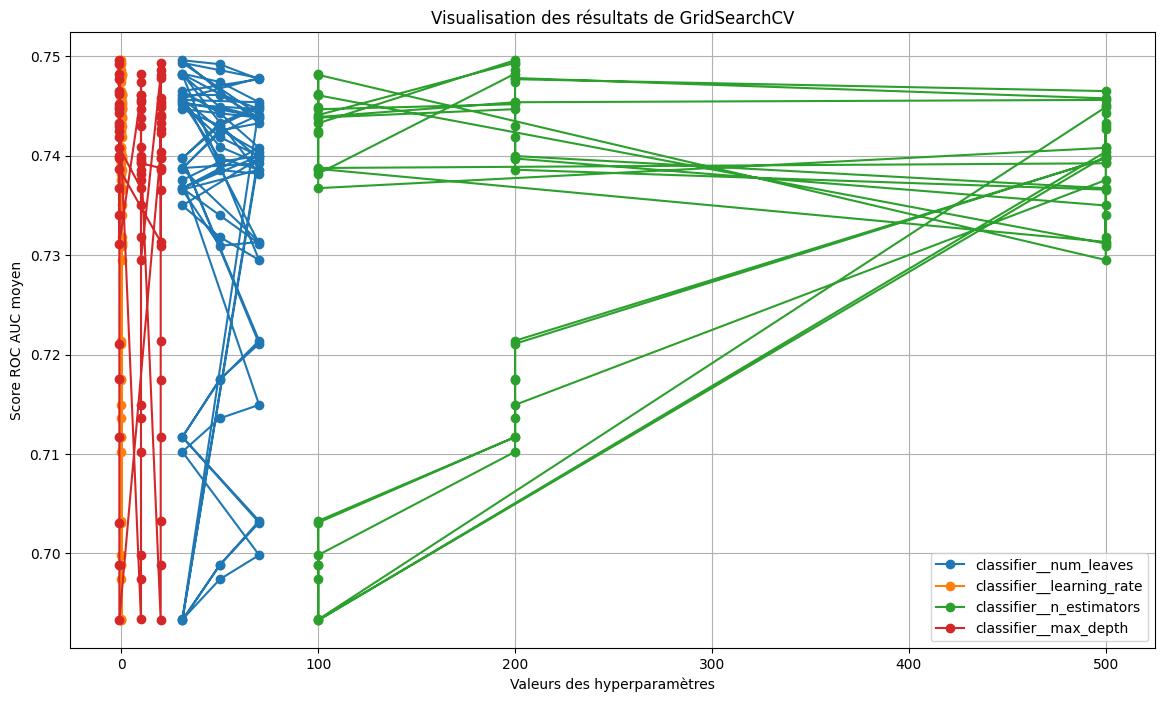

In [36]:
results = pd.DataFrame(grid_search.cv_results_)

plt.figure(figsize=(14,8))
for param in param_grid.keys():
    plt.plot(results['param_' + param],
    results['mean_test_score'],
    marker='o',
    linestyle='-',
    label=param
    )

plt.title('Visualisation des résultats de GridSearchCV')
plt.xlabel('Valeurs des hyperparamètres')
plt.ylabel('Score ROC AUC moyen')
plt.legend()
plt.grid(True)
plt.show()

In [ ]:
# display_info(message=f" Le meilleur algorithme sans amélioration des hyper paramètre {best_model_name}")

# # Paramètres pour GridSearchCV : on teste chaque modèle
# param_grid = {
#     'num_leaves': [31, 50, 70],
#     'learning_rate': [0.1, 0.05, 0.01],
#     'n_estimators': [100, 200, 500],
#     'max_depth': [-1, 10, 20]
# }
# model_pipeline = applyPipeline(models[best_model_name])

# grid_search = GridSearchCV(model_pipeline,param_grid, cv=5, scoring='roc_auc')

# display_info(message="on test notre model sur notre jeu de données de test")
# with timer(title=(f"Modelisation et prediction du model")):
#     model_pipeline.fit(X_train,y_train)
#     y_pred = model_pipeline.predict(X_test)
# display_info(message="on compare nos valeur predite sur notre jeu de données de test au valeur a predire y_test mis de côté")
# print(classification_report(y_test, y_pred))
# model.fit(X_train, y_train)

[LightGBM] [Info] Number of positive: 11284, number of negative: 11284
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.017809 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 38644
[LightGBM] [Info] Number of data points in the train set: 22568, number of used features: 217
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Info] Number of positive: 22584, number of negative: 22584
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.015142 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 42974
[LightGBM] [Info] Number of data points in the train set: 45168, number of used features: 222
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Info] Number of positive: 33885, number of negative: 33885
[LightGBM] [Info] Auto-choosing col-wise multi-

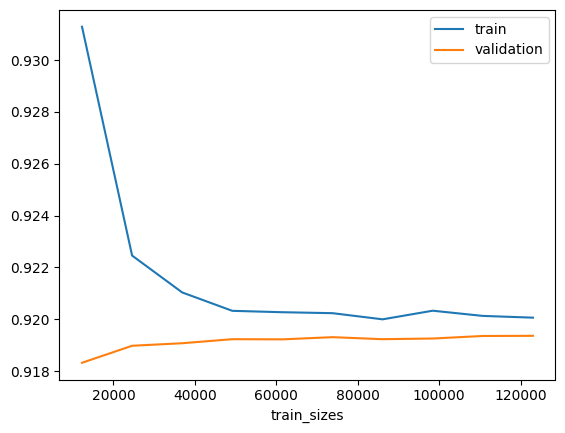

In [40]:
display_info(message="On peux tracer la learning curve ")
best_params = grid_search.best_params_
model_pipeline.set_params(**best_params)
N,train_score, val_score=learning_curve(model_pipeline, X_train, y_train, train_sizes=np.linspace(0.1,1.0,10),cv=5)

print(N)
plt.plot(N, train_score.mean(axis=1), label ='train')
plt.plot(N, val_score.mean(axis=1), label ='validation')
plt.xlabel('train_sizes')
plt.legend()